# ANOVA Analysis of NBA Players: Is bigger better?

For this project, I will be analysing the relationships between NBA players' height, weight and wingspan and their playing performance in some key statistical areas.

In [44]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pyhomogeneity as hg

# Getting the data
In order to get the dataset, I had to get the data from 2 sources. 

## Anthoprometric Data

The first source was https://www.nba.com/stats/draft/combine-anthro/. This page contains data on all draft classes (Incoming players from college that will be selected by pro teams) by year. This gave me data for the player anthroprometric data. This data had to be manually pasted into an excel document as exporting / auto-scraping the data was proving difficult. I went back as far as 03/04 (this is the draft class that contained LeBron James, who I'm quite sure will be the earliest player drafted given the criteria I'll be using in this project). I did not include players drafted in the last year as the previous NBA season (last complete one) was used.

The data had to be copied from the webpages and, in excel, 'Paste Special' had to be selected and 'Text' selected in the pop-up menu. The excel was then saved as a CSV and ready for cleaning.

In [2]:
# Custom headers are used to remove symbols that were causing issues
headers = ['Player', 'Position', 'Body Fat', 'Hand Length', 'Hand Width', 'Height', 'Height in Shoes', 'Standing Reach', 'Weight', 'Wingspan']

# Skips first row to skip headers in original doc
df = pd.read_csv('All_Draftees_02_20.csv', names = headers, skiprows = 1)
df.head()

,Player,Position,Body Fat,Hand Length,Hand Width,Height,Height in Shoes,Standing Reach,Weight,Wingspan
0,Kris Dunn,PG,-%,-,-,6' 3'',6' 4.25'',8' 4'',0,6' 9.5''
1,Tyler Ulis,PG,5.20%,7.5,7.5,5' 8.75'',5' 10'',7' 4.5'',149.2,6' 2''
2,John Lucas III,PG,-%,-,-,5' 9.25'',5' 10.5'',7' 8'',154.4,6' 0''
3,Russ Smith,PG,3.50%,8.25,8.5,5' 11.5'',6' 0.75'',7' 11'',160,6' 3.5''
4,Daryl Dorsey,PG,-%,-,-,5' 11.25'',6' 0.5'',7' 10'',160.8,5' 11.5''


#### Notes about measurements

- Both hand length and hand size are not included in some years so will not be used
- There are 2 different heights: with shoes and without shoes. Height without shoes has more measurements and will be used as more measurements are present
- Some players do not have measurements. These may have to be obtained by other means or the players ommitted from the analysis.

In [3]:
# Only include the data we will be analysing
nbadf = df[['Player', 'Position', 'Height', 'Weight', 'Wingspan']]
nbadf.head()

,Player,Position,Height,Weight,Wingspan
0,Kris Dunn,PG,6' 3'',0,6' 9.5''
1,Tyler Ulis,PG,5' 8.75'',149.2,6' 2''
2,John Lucas III,PG,5' 9.25'',154.4,6' 0''
3,Russ Smith,PG,5' 11.5'',160,6' 3.5''
4,Daryl Dorsey,PG,5' 11.25'',160.8,5' 11.5''


In [4]:
# Strip '' from right side of Heights and Wingspans
nbadf['Height'] = nbadf.loc[:,'Height'].str.strip('\'')
nbadf['Wingspan'] = nbadf.loc[:,'Wingspan'].str.strip('\'')
nbadf.head()

<ipython-input-4-692b6f63b3c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbadf['Height'] = nbadf.loc[:,'Height'].str.strip('\'')
<ipython-input-4-692b6f63b3c1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbadf['Wingspan'] = nbadf.loc[:,'Wingspan'].str.strip('\'')


,Player,Position,Height,Weight,Wingspan
0,Kris Dunn,PG,6' 3,0,6' 9.5
1,Tyler Ulis,PG,5' 8.75,149.2,6' 2
2,John Lucas III,PG,5' 9.25,154.4,6' 0
3,Russ Smith,PG,5' 11.5,160,6' 3.5
4,Daryl Dorsey,PG,5' 11.25,160.8,5' 11.5


In [5]:
# https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html
# Use string split to seperate feet and inches

nbadf[['Height Feet','Height Inches']] = nbadf.Height.str.split('\'', expand = True)
nbadf[['Wingspan Feet','Wingspan Inches']] = nbadf.Wingspan.str.split('\'', expand = True)
nbadf.head()

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Player,Position,Height,Weight,Wingspan,Height Feet,Height Inches,Wingspan Feet,Wingspan Inches
0,Kris Dunn,PG,6' 3,0,6' 9.5,6,3,6,9.5
1,Tyler Ulis,PG,5' 8.75,149.2,6' 2,5,8.75,6,2
2,John Lucas III,PG,5' 9.25,154.4,6' 0,5,9.25,6,0
3,Russ Smith,PG,5' 11.5,160,6' 3.5,5,11.5,6,3.5
4,Daryl Dorsey,PG,5' 11.25,160.8,5' 11.5,5,11.25,5,11.5


In [6]:
# https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html
# Use to numeric to convert column to ints / floats and calculate based on 1 foot = 40.48cm and 1 inch = 2.54cm
nbadf['Height'] = pd.to_numeric(nbadf['Height Feet']) * 30.48 + pd.to_numeric(nbadf['Height Inches']) * 2.54
nbadf['Wingspan'] = pd.to_numeric(nbadf['Wingspan Feet']) * 30.48 + pd.to_numeric(nbadf['Wingspan Inches']) * 2.54
nbadf.head()

<ipython-input-6-0bc900549f9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbadf['Height'] = pd.to_numeric(nbadf['Height Feet']) * 30.48 + pd.to_numeric(nbadf['Height Inches']) * 2.54
<ipython-input-6-0bc900549f9d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbadf['Wingspan'] = pd.to_numeric(nbadf['Wingspan Feet']) * 30.48 + pd.to_numeric(nbadf['Wingspan Inches']) * 2.54


,Player,Position,Height,Weight,Wingspan,Height Feet,Height Inches,Wingspan Feet,Wingspan Inches
0,Kris Dunn,PG,190.500,0,207.01,6,3,6,9.5
1,Tyler Ulis,PG,174.625,149.2,187.96,5,8.75,6,2
2,John Lucas III,PG,175.895,154.4,182.88,5,9.25,6,0
3,Russ Smith,PG,181.610,160,191.77,5,11.5,6,3.5
4,Daryl Dorsey,PG,180.975,160.8,181.61,5,11.25,5,11.5


In [7]:
# Remove '-' characters from Weight column
nbadf.loc[:,'Weight'] = nbadf.loc[:,'Weight'].str.strip('-')

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [8]:
# Convert weight to kg using 1 pound = 0.4536kg
nbadf['Weight'] = pd.to_numeric(nbadf['Weight'])*0.4536
nbadf.head()

<ipython-input-8-3cbebf5b53db>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbadf['Weight'] = pd.to_numeric(nbadf['Weight'])*0.4536


,Player,Position,Height,Weight,Wingspan,Height Feet,Height Inches,Wingspan Feet,Wingspan Inches
0,Kris Dunn,PG,190.500,0.00000,207.01,6,3,6,9.5
1,Tyler Ulis,PG,174.625,67.67712,187.96,5,8.75,6,2
2,John Lucas III,PG,175.895,70.03584,182.88,5,9.25,6,0
3,Russ Smith,PG,181.610,72.57600,191.77,5,11.5,6,3.5
4,Daryl Dorsey,PG,180.975,72.93888,181.61,5,11.25,5,11.5


In [9]:
nbadf = nbadf[['Player', 'Position', 'Height', 'Weight', 'Wingspan']]
nbadf.head()

,Player,Position,Height,Weight,Wingspan
0,Kris Dunn,PG,190.500,0.00000,207.01
1,Tyler Ulis,PG,174.625,67.67712,187.96
2,John Lucas III,PG,175.895,70.03584,182.88
3,Russ Smith,PG,181.610,72.57600,191.77
4,Daryl Dorsey,PG,180.975,72.93888,181.61


In [10]:
# Remove NaNs and 0 values
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

# Only first row has a 0 value so that row will be removed
nbadf = nbadf.loc[1:,:]

# Count rows before drop
print(nbadf.count())

# inplace = True to drop from original df
nbadf.dropna(inplace=True)

# Count rows after drop
nbadf.count()

Player      1169
Position    1164
Height      1156
Weight      1155
Wingspan    1157
dtype: int64


Player      1154
Position    1154
Height      1154
Weight      1154
Wingspan    1154
dtype: int64

In [11]:
nbadf.head()

,Player,Position,Height,Weight,Wingspan
1,Tyler Ulis,PG,174.625,67.67712,187.96
2,John Lucas III,PG,175.895,70.03584,182.88
3,Russ Smith,PG,181.610,72.57600,191.77
4,Daryl Dorsey,PG,180.975,72.93888,181.61
5,Aaron Brooks,PG,177.800,73.02960,193.04


## Player Performance Data

The source of the player performance data in this analysis was [BasketballReference.com](https://www.basketball-reference.com/), a great site for NBA stats. The data used will be performance data from the 2020/2021 NBA season which was the last full season played. Performance data was recorded **per 36 minutes**, which accounts for difference in playing time among players as rolling subs are used and a player will rarely play a full 48 minute game. Often, normalising NBA stats to 36 minutes creates some outliers at the lower end of minutes played e.g. a player who plays for 1 minute and scores 3 points will have a point-per-36 minutes of 108 points, which would break the record for points scored in a game with 12 minutes to spare. To prevent this, the top 300 players in total minutes played were used for this analysis, which is roughly the top 9 or 10 players in minutes played per team i.e. the starters and frequently used subs.

To get the data into a dataframe, the data was exported into excel format directly from the site, sorted by minuted played. Then players outside the top 200 were removed and the 'rank' column that ranked players based on minutes played was also removed. The excel was then saved as a csv.

In [12]:
# Skips first row to skip headers in original doc
df = pd.read_csv('Player_Performance_20_21.csv')
df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Julius Randle,PF,26,NYK,71,71,2667,8.1,17.8,0.456,...,0.811,1.1,8.6,9.8,5.8,0.9,0.2,3.3,3.0,23.1
1,RJ Barrett,SG,20,NYK,72,72,2511,6.7,15.2,0.441,...,0.746,1.0,5.0,5.9,3.1,0.8,0.3,2.0,2.7,18.1
2,Nikola Jokić,C,25,DEN,72,72,2488,10.6,18.7,0.566,...,0.868,3.0,8.3,11.3,8.7,1.4,0.7,3.2,2.8,27.5
3,Buddy Hield,SG,28,SAC,71,71,2433,6.0,14.7,0.406,...,0.846,0.4,4.5,4.9,3.8,0.9,0.4,1.9,2.6,17.4
4,Damian Lillard,PG,30,POR,67,67,2398,9.0,20.0,0.451,...,0.928,0.5,3.8,4.2,7.6,0.9,0.3,3.0,1.5,28.9


In [13]:
# Filter df by columns that we want
ppdf = df[["Player", "Pos", "PTS", "TRB", "AST", "BLK", "STL", "TOV"]]

In [14]:
ppdf.head()

,Player,Pos,PTS,TRB,AST,BLK,STL,TOV
0,Julius Randle,PF,23.1,9.8,5.8,0.2,0.9,3.3
1,RJ Barrett,SG,18.1,5.9,3.1,0.3,0.8,2.0
2,Nikola Jokić,C,27.5,11.3,8.7,0.7,1.4,3.2
3,Buddy Hield,SG,17.4,4.9,3.8,0.4,0.9,1.9
4,Damian Lillard,PG,28.9,4.2,7.6,0.3,0.9,3.0


#### Secondary Positions
Some player have secondary positions on Bballref.com e.g. Centre-Power Forward. For the purposes of this analysis, we will be taking the first position listed as the player's primary position.

In [15]:
ppdf.iloc[20]

Player    Norman Powell
Pos               SG-SF
PTS                20.9
TRB                 3.5
AST                 2.1
BLK                 0.3
STL                 1.3
TOV                 1.9
Name: 20, dtype: object

In [16]:
ppdf['Pos'] = ppdf.Pos.str.split('\-', expand = True)

<ipython-input-16-56a20e42e5c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppdf['Pos'] = ppdf.Pos.str.split('\-', expand = True)


In [17]:
ppdf.head()

,Player,Pos,PTS,TRB,AST,BLK,STL,TOV
0,Julius Randle,PF,23.1,9.8,5.8,0.2,0.9,3.3
1,RJ Barrett,SG,18.1,5.9,3.1,0.3,0.8,2.0
2,Nikola Jokić,C,27.5,11.3,8.7,0.7,1.4,3.2
3,Buddy Hield,SG,17.4,4.9,3.8,0.4,0.9,1.9
4,Damian Lillard,PG,28.9,4.2,7.6,0.3,0.9,3.0


In [18]:
ppdf.iloc[20]

Player    Norman Powell
Pos                  SG
PTS                20.9
TRB                 3.5
AST                 2.1
BLK                 0.3
STL                 1.3
TOV                 1.9
Name: 20, dtype: object

### Joining the dataframes
Both dataframes will have to be joined before analysing. After joining, specific cases will be looked at where there are no corresponding anthroprometric data.

In [19]:
combine = ppdf.merge(nbadf, on = "Player", how = 'left')

In [20]:
combine.head()

,Player,Pos,PTS,TRB,AST,BLK,STL,TOV,Position,Height,Weight,Wingspan
0,Julius Randle,PF,23.1,9.8,5.8,0.2,0.9,3.3,PF,202.565,113.26392,213.360
1,RJ Barrett,SG,18.1,5.9,3.1,0.3,0.8,2.0,NaN,NaN,NaN,NaN
2,Nikola Jokić,C,27.5,11.3,8.7,0.7,1.4,3.2,NaN,NaN,NaN,NaN
3,Buddy Hield,SG,17.4,4.9,3.8,0.4,0.9,1.9,SG,192.405,96.34464,206.375
4,Damian Lillard,PG,28.9,4.2,7.6,0.3,0.9,3.0,PG,187.325,85.63968,202.565


In [21]:
# Drop second position columns
combine = combine.drop('Position', axis=1)

In [22]:
combine.head()

,Player,Pos,PTS,TRB,AST,BLK,STL,TOV,Height,Weight,Wingspan
0,Julius Randle,PF,23.1,9.8,5.8,0.2,0.9,3.3,202.565,113.26392,213.360
1,RJ Barrett,SG,18.1,5.9,3.1,0.3,0.8,2.0,NaN,NaN,NaN
2,Nikola Jokić,C,27.5,11.3,8.7,0.7,1.4,3.2,NaN,NaN,NaN
3,Buddy Hield,SG,17.4,4.9,3.8,0.4,0.9,1.9,192.405,96.34464,206.375
4,Damian Lillard,PG,28.9,4.2,7.6,0.3,0.9,3.0,187.325,85.63968,202.565


In [23]:
# Look at NaNs
nan = combine[combine['Height'].isna()]

In [24]:
# This option allows a full look at the dataframe
# pd.set_option('display.max_rows', None)

In [25]:
nan.head()

,Player,Pos,PTS,TRB,AST,BLK,STL,TOV,Height,Weight,Wingspan
1,RJ Barrett,SG,18.1,5.9,3.1,0.3,0.8,2.0,NaN,NaN,NaN
2,Nikola Jokić,C,27.5,11.3,8.7,0.7,1.4,3.2,NaN,NaN,NaN
7,Andrew Wiggins,PF,20.1,5.3,2.5,1.1,1.0,1.9,NaN,NaN,NaN
8,Mikal Bridges,SF,14.9,4.7,2.3,1.0,1.2,0.9,NaN,NaN,NaN
9,Nikola Vučević,C,25.1,12.5,4.1,0.7,1.0,1.9,NaN,NaN,NaN


In [26]:
# Remove NaNs from dataframe
combine = combine.dropna()

In [27]:
combine.head()

,Player,Pos,PTS,TRB,AST,BLK,STL,TOV,Height,Weight,Wingspan
0,Julius Randle,PF,23.1,9.8,5.8,0.2,0.9,3.3,202.565,113.26392,213.360
3,Buddy Hield,SG,17.4,4.9,3.8,0.4,0.9,1.9,192.405,96.34464,206.375
4,Damian Lillard,PG,28.9,4.2,7.6,0.3,0.9,3.0,187.325,85.63968,202.565
5,Terry Rozier,SG,21.3,4.6,4.4,0.4,1.3,1.9,184.150,86.27472,203.835
6,Russell Westbrook,PG,22.0,11.4,11.6,0.3,1.4,4.7,188.595,87.09120,202.565


In [28]:
# Count remaining datapoints
combine.count()

Player      180
Pos         180
PTS         180
TRB         180
AST         180
BLK         180
STL         180
TOV         180
Height      180
Weight      180
Wingspan    180
dtype: int64

In [29]:
# Assign positional dataframes
pgdf = combine.loc[combine['Pos'] == 'PG']
sgdf = combine.loc[combine['Pos'] == 'SG']
sfdf = combine.loc[combine['Pos'] == 'SF']
pfdf = combine.loc[combine['Pos'] == 'PF']
cdf = combine.loc[combine['Pos'] == 'C']

In [30]:
print(pgdf.count())
print(sgdf.count())
print(sfdf.count())
print(pfdf.count())
print(cdf.count())

Player      31
Pos         31
PTS         31
TRB         31
AST         31
BLK         31
STL         31
TOV         31
Height      31
Weight      31
Wingspan    31
dtype: int64
Player      53
Pos         53
PTS         53
TRB         53
AST         53
BLK         53
STL         53
TOV         53
Height      53
Weight      53
Wingspan    53
dtype: int64
Player      26
Pos         26
PTS         26
TRB         26
AST         26
BLK         26
STL         26
TOV         26
Height      26
Weight      26
Wingspan    26
dtype: int64
Player      41
Pos         41
PTS         41
TRB         41
AST         41
BLK         41
STL         41
TOV         41
Height      41
Weight      41
Wingspan    41
dtype: int64
Player      29
Pos         29
PTS         29
TRB         29
AST         29
BLK         29
STL         29
TOV         29
Height      29
Weight      29
Wingspan    29
dtype: int64


#### NB
The numbers of each position should be noted as it may affect normality distributions later on (Centers will tend to have more rebounds, Point Guards more assists etc.)

In [31]:
combine.mean()

PTS          16.853333
TRB           6.517222
AST           3.665000
BLK           0.735000
STL           1.117778
TOV           1.951111
Height      196.461944
Weight       96.007464
Wingspan    208.953806
dtype: float64

## Visualisation of Data

In [32]:
# Assign variables to columns for visualisation
position = combine['Pos']
height = combine['Height']
weight = combine['Weight']
wingspan = combine['Wingspan']
points = combine['PTS']
rebounds = combine['TRB']
assists = combine['AST']
blocks = combine['BLK']
steals = combine['STL']
turnovers = combine['TOV']

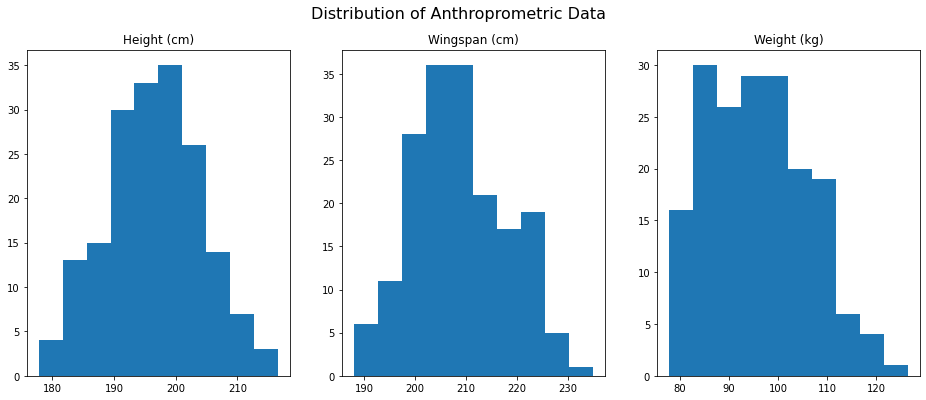

In [33]:
# Histograms to check for normal distribution of anthroprometric data
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize = (16,6))

fig.suptitle('Distribution of Anthroprometric Data', fontsize=16)

ax1.hist(height, bins=10)
ax1.set_title('Height (cm)')

ax2.hist(wingspan, bins=10)
ax2.set_title('Wingspan (cm)')

ax3.hist(weight, bins=10)
ax3.set_title('Weight (kg)');


While not anywhere close to the means of a normal population (the average height is about 196cm or just over 6ft4"), the anthroprometric data seems to be normally distributed, with weight having somewhat of a positive skewness.

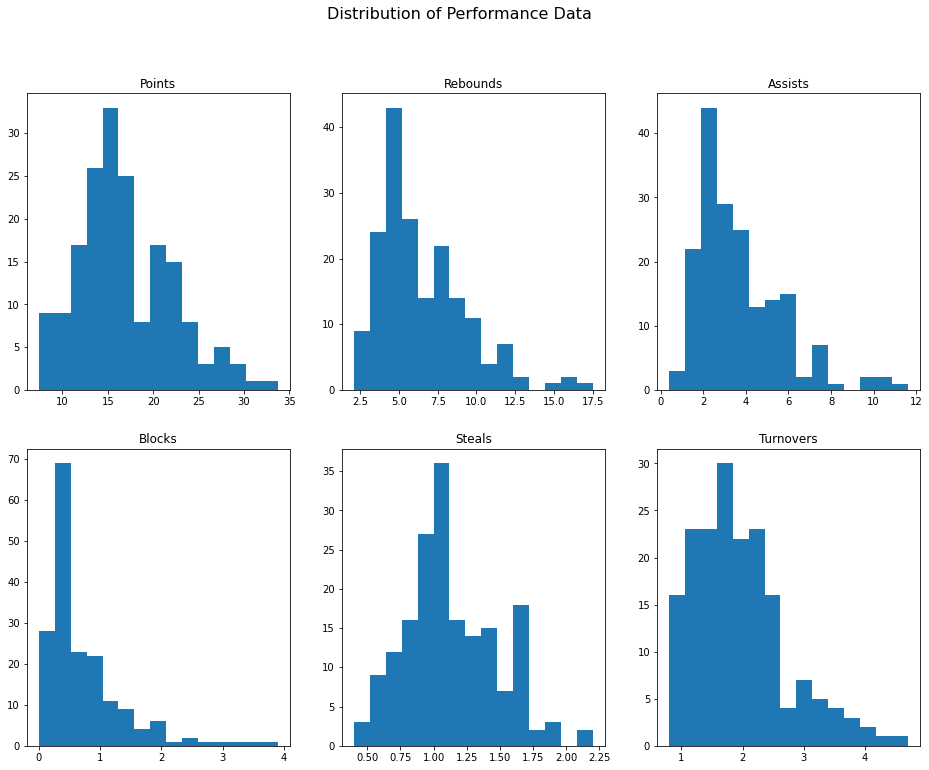

In [34]:
# Histograms to check for normal distribution of performance data
fig, [[ax1, ax2, ax3],[ax4, ax5, ax6]] = plt.subplots(ncols=3, nrows=2, figsize = (16,12))

fig.suptitle('Distribution of Performance Data', fontsize=16)

ax1.hist(points, bins=15)
ax1.set_title('Points')

ax2.hist(rebounds, bins=15)
ax2.set_title('Rebounds')

ax3.hist(assists, bins=15)
ax3.set_title('Assists')
      
ax4.hist(blocks, bins=15)
ax4.set_title('Blocks')

ax5.hist(steals, bins=15)
ax5.set_title('Steals')

ax6.hist(turnovers, bins=15)
ax6.set_title('Turnovers');

### Positive Skewness
All of the visualisation above seem to be positively-skewed. For the bottom 3 plots, this may be due to the average being close to 0 (it is impossible to have -1 of any of the categories). Despite the skewness, the data resembles a normal distribution. In any case, these are all depenmdant variables and do not necessarily need to be normally distributed.

## ANOVA Assumptions
ANOVA assumes [3 things.](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/anova/) These are:

 - Population is normally distributed
 - Samples are independant of each other
 - Homogeneity of Variance

### Normally Distributed Population
Visual tests above for the 3 independant variables indicate that the populations are normally distributed. Below are Shapiro-Wilks tests for normality.

In [42]:
# https://towardsdatascience.com/normality-tests-in-python-31e04aa4f411

normaltests = [height, weight, wingspan]
for x in normaltests:
    stat, p = shapiro(x)
    print(f'Normality test for {x.name}')
    print('stat=%.3f, p=%.3f' % (stat,p))
    if p > 0.05:
        print('Probably Gaussian\n\n')
    else:
        print('Probably not Gaussian\n\n')

Normality test for Height
stat=0.995, p=0.843
Probably Gaussian


Normality test for Weight
stat=0.978, p=0.006
Probably not Gaussian


Normality test for Wingspan
stat=0.987, p=0.085
Probably Gaussian




Height and Wingspan can be considered normally distributed according to the tests above. Weight cannot be considered normally distributed, even though the histogram may appear to be (albeight with some amount of skewness). We will use weight as a variable anyway but keep in mind that it did not pass this test.

### Independant Samples
The data used can be considered independant as the variables do not impact each other across samples. One player's weight can no impact on another player's weight, same for height etc.

### Homogeneity of Variance
Below are Pettit tests for Homogeneity of Variance for the 3 independant variables.

In [45]:
# https://pypi.org/project/pyhomogeneity/
for x in normaltests:
    result = hg.pettitt_test(x)
    print(f'Homogeneity test for {x.name}')
    print(result, "\n\n")

Homogeneity test for Height
Pettitt_Test(h=False, cp=19, p=0.3949, U=1199.0, avg=mean(mu1=192.2044736842105, mu2=196.96437888198759)) 


Homogeneity test for Weight
Pettitt_Test(h=False, cp=22, p=0.6355, U=988.0, avg=mean(mu1=91.7550327272727, mu2=96.5995746835443)) 


Homogeneity test for Wingspan
Pettitt_Test(h=False, cp=28, p=0.4378, U=1161.0, avg=mean(mu1=205.58124999999998, mu2=209.5750657894737)) 




A h score of False indicates that the variables are homogenous. All 3 variables can be deemed homogenous.

### ANOVA Assumptions Summary
All 3 independant variable pass the 2nd and 3rd assumption for ANOVA testing as the sample are independant of each other and the variables are homogenou. On the weight variable did not pass the tests for normality, however we we still include it in our ANOVA testing.